<a href="https://colab.research.google.com/github/danjohnvelasco/AI-Sandbox/blob/master/Logistic_Regression_(from_scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

A one layer neural network for binary classification of images.

It's a bird? It's a plane?

## Steps
1. Get Data
2. Preprocess Data
3. Forward Pass
4. Backward Pass
5. Optimizer (Gradient Descent)
6. Training Func
7. Predict Func
8. Plot losses
9. Refactor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Get Data

In [ ]:
def get_cifar():
    import requests

    # download link
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

    # download file
    r = requests.get(url, allow_redirects=True)

    # save file
    open('cifar.tar.gz', 'wb').write(r.content)

In [ ]:
# download data to machine
get_cifar()

In [ ]:
# extract data
!tar xvzf cifar.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def load_CIFAR_batch(filename):
    import pickle

    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    import os

    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [279]:
# Load the raw CIFAR-10 data.
cifar10_dir = "cifar-10-batches-py/"
X_train_raw, y_train_raw, X_test_raw, y_test_raw = load_CIFAR10(cifar10_dir)

# Tests
assert(X_train_raw.shape == (50000, 32, 32, 3))
assert(y_train_raw.shape == (50000,))
assert(X_test_raw.shape == (10000, 32, 32, 3))
assert(y_test_raw.shape == (10000,))

# Print out the sizes of the training and test data.
print('Training data shape: ', X_train_raw.shape)
print('Training labels shape: ', y_train_raw.shape)
print('Test data shape: ', X_test_raw.shape)
print('Test labels shape: ', y_test_raw.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


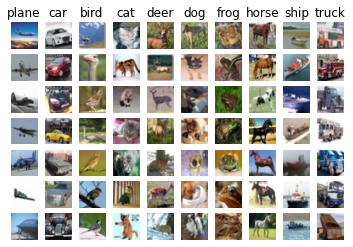

In [276]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train_raw == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_raw[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Convert to binary classification problem (bird == 1 or plane == 0)


In [281]:
train_idx_plane = np.where(y_train_raw == 0)[0]
train_idx_bird = np.where(y_train_raw == 2)[0]
test_idx_plane = np.where(y_test_raw == 0)[0]
test_idx_bird = np.where(y_test_raw == 2)[0]

# Tests
train_class_count = np.bincount(y_train_raw)
test_class_count = np.bincount(y_test_raw)

assert(train_idx_plane.shape[0] == train_class_count[0]) 
assert(train_idx_bird.shape[0] == train_class_count[2])
assert(test_idx_plane.shape[0] == test_class_count[0])
assert(test_idx_bird.shape[0] == test_class_count[2])

train_idx_plane.shape, train_idx_bird.shape, test_idx_plane.shape, test_idx_bird.shape

((5000,), (5000,), (1000,), (1000,))

In [300]:
# Get plane/bird images subset

# Set random seed for reproducibility
np.random.seed(2021)

# Convert bird label from 2 to 1
y_train_raw[train_idx_bird] = 1
y_test_raw[test_idx_bird] = 1

mask = np.concatenate((train_idx_bird, train_idx_plane), axis=0)
np.random.shuffle(mask) # shuffle inplace
X_train = X_train_raw[mask]
y_train = y_train_raw[mask]

mask = np.concatenate((test_idx_bird, test_idx_plane), axis=0)
np.random.shuffle(mask) # shuffle inplace

X_test = X_test_raw[mask]
y_test = y_test_raw[mask]

# Reshape y_train and y_test to row vector
y_train = y_train.reshape(1, y_train.shape[0])
y_test = y_test.reshape(1, y_test.shape[0])



# Tests
assert(X_train.shape[0] == 10000)
assert(y_train.shape == (1,10000))
assert(X_test.shape[0] == 2000)
assert(y_test.shape == (1,2000))

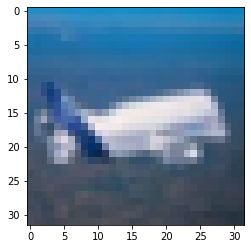

In [301]:
plt.imshow(X_train[402].reshape(32,32,3).astype('uint8'))

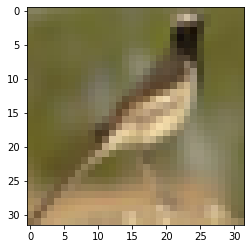

In [303]:
plt.imshow(X_train[7500].reshape(32,32,3).astype('uint8'))

## Preprocess Data

In [304]:
def tfms_flatten(X):
    '''
    Returns a flattened (row vector) image.
    Transforms n-dimensional numpy array into a row vector (n, n_instances)

    Inputs:
    - X: An n-dimensional numpy array

    Returns:
    - A numpy array of shape (n, n_instances). Where n_instances is the number of
      images in a dataset and n is the number of dimensions.
    '''
    return np.reshape(X, (-1, X.shape[0]))

def standardize_img(X):
    '''
    Returns the standardized version of the input.

    Rescales the image data by from 0-255 to 0-1 dividing each element of X
    by max pixel value (255).

    Inputs:
    - X: An n-dimensional numpy array

    Returns:
    - A standardized image data
    '''
    return X/255

In [305]:
# Flatten image
X_train_flatten = tfms_flatten(X_train)
X_test_flatten = tfms_flatten(X_test)

# Tests
# ensures that the data is a subset
assert(X_train_flatten.shape == (3072, 10000))
assert(X_test_flatten.shape == (3072, 2000))


print(X_train_flatten.shape, X_test_flatten.shape)

(3072, 10000) (3072, 2000)


In [306]:
# Standardize
X_train = standardize_img(X_train_flatten)
X_test = standardize_img(X_test_flatten)

print(X_train.shape, X_test.shape)

(3072, 10000) (3072, 2000)


## Forward Pass

In [307]:
def zero_init(n_dim):
    '''
    Returns an ndarray of size (n_dim, 1) and a scalar.

    Initialize weights and bias term.

    Input:
    - n_dim : int
        Number of dimensions
    Returns:
    - w : ndarray
        An ndarray of zeroes
    - b : ndarray
        A zero scalar
    '''
    w = np.zeros((n_dim, 1))
    b = 0

    return w, b

In [308]:
def random_init(n_dim):
    '''
    Returns an ndarray of size (n_dim, 1) with random values 
    and a scalar of random value.

    Initialize weights and bias with random values.

    Input:
    - n_dim : int
        Number of dimensions

    Returns:
    - w : ndarray
        An ndarray of random values
    - b : ndarray
        A scalar with random value
    '''
    w = np.random.rand(n_dim,1)
    b = np.random.rand(1,)[0] # scalar

    return w, b

In [378]:
def sigmoid(z):
    '''
    Returns an ndarray with the sigmoids of the input.
    '''
    return 1/(1+np.exp(-1*z))

In [402]:
def negative_logres_cost(y, y_pred):
    y = y.reshape(1, y.shape[1]) # ensure shape (1, y_instances)
    y_1 =  y * np.log(y_pred) # if y == 1
    y_0 = (1-y) * np.log(1 - y_pred) # if y == 0
    cost = np.sum(y_1 + y_0)/(-1 * y_pred.shape[1])
    return cost

# Getting back to work (delete this sections once done)

Be able to compute the derivatives of cost wrt weights or bias by hand.

derivative of sigmoid: https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e

In [403]:
def forward_backward_pass(w, b, X, y):
    '''
    Returns weights, biases, and respective gradients with respect to 
    some loss function.

    Forward pass: calculates sigmoid(z) to get predictions and get cost
    Backward pass: calculate gradients of w and b with respect to cost

    Inputs:
    - w : ndarray
        weights of size (n, 1) where n is the number of dimensions
    - b : scalar
        bias term
    
    Returns: (ARE YOU SURE?)
    - parameters : dict
        A dictionary of weight and biases
    - grads : dict
        A dictionary of gradients
    '''
    # Forward Pass
    # Layer 1
    i_h = np.dot(w.T, X) + b # input to hidden
    # Activation
    h_o = sigmoid(i_h) # hidden to output


    # Loss
    cost = negative_logres_cost(y, h_o)
    print(cost)

    # Backward Pass
    


    return h_o
    #return w, b

In [407]:
# Initialize parameters
n_dim = X_train.shape[0] # 3072
w, b = zero_init(n_dim)

# Tests
assert(w.shape == (3072, 1))
assert(np.isscalar(b))

In [406]:
y_pred = forward_backward_pass(w, b, X_train, y_train)

0.6931471805599453


array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [ ]:
y

9